# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [309]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [310]:
### Replace each question mark with the appropriate value.
import numpy as np
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [311]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

def visualize(X_train, y_train) :
        indx = np.arange(y_train.shape[0])
        np.random.shuffle(indx)
        # create subplot and fill with images
        f, e = plt.subplots(10, 3)
        for i in range(10):
            for j in range(3):
                e[i, j].imshow(X_train[indx[j+10*i]])
                plt.setp(e[i,j].get_xticklabels(), visible=False)
                plt.setp(e[i,j].get_yticklabels(), visible=False)
        plt.show()
        
#visualize(X_train, y_train)


In [312]:
   
def visualize_distribution(y_test, y_train):
    plt.figure(1)
    n, bins, patches = plt.hist(y_train, 70, facecolor='green', alpha=0.75)

    plt.xlabel('Train Label Classes')
    plt.ylabel('Train Label Samples Number')
    plt.title('Training Samples Distribution')
    plt.grid(True)

    plt.figure(2)
    n, bins, patches = plt.hist(y_test,70, facecolor='green', alpha=0.75)

    plt.xlabel('Test Label Classes')
    plt.ylabel('Test Label Samples Number')
    plt.title('Test Samples Distribution')
    plt.grid(True)
    plt.show()
    
#visualize_distribution(y_test, y_train)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [313]:
from skimage import exposure, color
import cv2
import time
from tqdm import tqdm

class DataPreprocessor(object) :
    
    def simple_rescale(self,image):
        image = ((image / 255. )* 0.8)+ 0.1
        return image

    def mean_substract(self,image):
        #np.mean(images, axis = 0,dtype=np.uint8)
        image -= np.mean(image, axis = 0,dtype=np.uint8)
        return image

    def feature_standardization(self, image):
        image = image / np.std(image, axis = 0)
        return image

    def exposure(self,image):
        return exposure.equalize_adapthist(image)
   
    def gray(self, image):
        return color.rgb2gray(image)#, cv2.COLOR_BGR2GRAY)

    def preprocess(self,image):
        #image = substract_noise(image)
        imag = self.gray(image)
        #image = self.simple_rescale(image)
        #image = self.mean_substract(image)
        #image = self.exposure(image)
        return imag


    def preprocess_batch(self,images):
        #imgs = np.copy(images)
        imgs=[]
        print('image shape : ',images[0].shape)
        for i in tqdm(range(images.shape[0])):
            #imgs[i] = self.preprocess(images[i])
            imgs.append(self.preprocess(images[i]))
        return np.asarray(imgs).reshape(images.shape[0],images.shape[1],images.shape[2])
    '''
    def preprocess_batch(self,X):
        #Convert to grayscale, e.g. single Y channel
        X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
        #Scale features to be in [0, 1]
        X = (X / 255.).astype(np.float32)

        # Apply localized histogram localization  
        for i in tqdm(range(X.shape[0])):
            X[i] = exposure.equalize_adapthist(X[i])
        
        # Add a single grayscale channel
        X = X.reshape(X.shape + (1,)) 
        return X
    '''

In [314]:
import matplotlib.pyplot as plt
# Test preprocessing algorithm on one image
'''
plt.figure(1)
plt.imshow(X_test[549])
dp = DataPreprocessor()
X_test = dp.preprocess_batch(X_test)
print(X_test.shape)
plt.figure(2)
plt.imshow(X_test[549])
plt.show()
#X_test = dp.preprocess_batch(X_test)
'''


'\nplt.figure(1)\nplt.imshow(X_test[549])\ndp = DataPreprocessor()\nX_test = dp.preprocess_batch(X_test)\nprint(X_test.shape)\nplt.figure(2)\nplt.imshow(X_test[549])\nplt.show()\n#X_test = dp.preprocess_batch(X_test)\n'

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

# Data Preprocessing

The preprocess stage aims to :
  1.Normalize data

1.Data Normalization : in order to make the learning process performing better. The CNN learns its weights by adding gradient error vectors multiplied by the learning rate computed from backprop to weight matrices as the training process is running. so we end up with the following equation :
W = W + (learningrate * gradient descent)

Initial conditions : At the begining of the learning process, the input features values distributions are different for each one (feature). Thus the learning rate would correct in each dimension from one another. it might be over compensating a correction in one weight dimension while undercompensating in another.

The gradient descent find itself oscillating and unable to center or moving slowly  onto a better minima. So therefore, to reach a better minima and avoiding the oscillation (see above)  we need to normalize the input features values.

The scenario for preprocessing dataset is based on dataset normalization using three following methods to compare the average error (%) for each (http://ijssst.info/Vol-15/No-2/data/3251a024.pdf §IV. RESULTS AND DISCUSSIONS.)

The methods are :
    1.Simple Rescale
    2.Substract Mean 
    


Each normalization methods is implemented by a "normalized" pipeline (see "class DataPreProcessor" bellow).
The normalization is part of the preprocess stage and should be applied after the Data augmentation stage (see later "class DataAugmenter") if exists.




In [315]:
#apply_preprocessing(X_train, y_train,True) 

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

# Data Augmentation and Spliting

Data augmentation is done to artificially increase the size of the dataset. Various affine transformations are applied to slightly perturb each image so that the network will receive a different variation of each image on every iteration.

Random rotations between -10 and 10 degrees.
Random translation between -10 and 10 pixels in any direction.
Random zoom between factors of 1 and 1.3.
Random shearing between -25 and 25 degrees.
Bool choice to invert colors.
Sobel edge detector applied to 1/4 of images.


In [316]:
from skimage import transform, filters, exposure, img_as_float
from skimage.transform import rescale
from random import randint,uniform
import cv2

class DataAugmenter(object):
    def fast_warp(self, img, tf, output_shape, mode='wrap'):
        return transform._warps_cy._warp_fast(img, tf.params,
                                          output_shape=output_shape, mode=mode)

    def augment(self,images):
        # set empty copy to hold augmented images so that we don't overwrite
        #print(images.shape)
        #print(images[1][:,:][:,:])
        images_aug = np.empty(shape = (images.shape[0], images.shape[1],images.shape[2],images.shape[3]),
                               dtype = 'float32')
        print(images_aug[0].shape)

        # random rotations betweein -10 and 10 degrees
        dorotate = randint(-10,10)

        # random translations
        trans_1 = randint(-10,10)
        trans_2 = randint(-10,10)

        # random zooms
        zoom = uniform(1, 1.3)

        # shearing
        shear_deg = uniform(-25, 25)

        # set the transform parameters for skimage.transform.warp
        # have to shift to center and then shift back after transformation otherwise
        # rotations will make image go out of frame
        center_shift   = np.array((32, 32)) / 2. - 0.5
        tform_center   = transform.SimilarityTransform(translation=-center_shift)
        tform_uncenter = transform.SimilarityTransform(translation=center_shift)

        tform_aug = transform.AffineTransform(rotation = np.deg2rad(dorotate),
                                              scale =(1/zoom, 1/zoom),
                                              shear = np.deg2rad(shear_deg),
                                              translation = (trans_1, trans_2))

        #tform = tform_center + tform_aug + tform_uncenter

        #output = numpy.empty(images.shape[1],images.shape[2],images.shape[3]),dtype=numpy.float32)
        tform = tform_aug 

        
        for j in range(images.shape[0]):
            for channel in range(images.shape[3]):
                images_aug[j][:, :,channel] = self.fast_warp(
                                                    images[j][:, :,channel],
                                                    tform,
                                                    output_shape=(images.shape[1],images.shape[2],images.shape[3]))
        
        
        '''
        # use sobel edge detector filter on one quarter of the images
        indices_sobel = np.random.choice(images_aug.shape[0],
                                         images_aug.shape[0] / 4, replace = False)
        for k in indices_sobel:
            for channel in range(images.shape[3]):
                print(rescale(images_aug[k][:, :,channel],.5))
                images_aug[k][:, :,channel] = filters.sobel(rescale(images_aug[k][:, :,channel],.5))
        
        # invert half of the images
        indices_invert = np.random.choice(images_aug.shape[0],
                                          images_aug.shape[0] / 2, replace = False)
        for l in indices_invert:
            for channel in range(images.shape[3]):
                img = images_aug[l][:, :,channel]
                images_aug[l][:, :,channel] = np.absolute(img - np.amax(img))
         '''   
        return images_aug
    
    def augment_batch(self,images,effect):
        #images_aug = np.empty(shape = (images.shape[0], images.shape[1],images.shape[2],images.shape[3]),
        #                      dtype = 'float32')
        
        
        imgs = []
        for image in images :
            img = self.transform_image(image,30,5,5)
            imgs.append(img)# use sobel edge detector filter on one quarter of the images
        
        
        '''
        images_aug = np.asarray(imgs)
        print(images_aug.shape)
        indices_sobel = np.random.choice(images_aug.shape[0],
                                         images_aug.shape[0] / 4, replace = False)
        for k in indices_sobel:
        '''
        images_aug = np.asarray(imgs)
        print(images_aug.shape)
        if effect=='soble':
            for k in range(images_aug.shape[0]):
                #print(rescale(images_aug[k][:, :,channel],.5))
                images_aug[k][:, :] = filters.sobel(images_aug[k][:, :])
            
        '''
        indices_sobel = np.random.choice(images_aug.shape[0],
                                         images_aug.shape[0] / 4, replace = False)
        
        for k in indices_sobel:
            #print(rescale(images_aug[k][:, :,channel],.5))
            images_aug[k][:, :] = filters.sobel(images_aug[k][:, :])
        
        # invert half of the images
        indices_invert = np.random.choice(images_aug.shape[0],
                                          images_aug.shape[0] / 2, replace = False)
        for l in indices_invert:
        '''
        if effect=='invert':
            for l in range(images_aug.shape[0]):
                images_aug[l][:, :] = np.absolute(images_aug[l][:, :] - np.amax(img))
        
        return  np.asarray(images_aug).reshape(images.shape[0],images.shape[1],images.shape[2])
        
    def transform_image(self,image,ang_range,shear_range,trans_range):

        # Rotation

        ang_rot = np.random.uniform(ang_range)-ang_range/2
        rows = image.shape[0]
        cols = image.shape[1]
        #ch = image.shape[2]
        Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

        # Translation
        tr_x = trans_range*np.random.uniform()-trans_range/2
        tr_y = trans_range*np.random.uniform()-trans_range/2
        Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

        # Shear
        pts1 = np.float32([[5,5],[20,5],[5,20]])

        pt1 = 5+shear_range*np.random.uniform()-shear_range/2
        pt2 = 20+shear_range*np.random.uniform()-shear_range/2

        pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

        shear_M = cv2.getAffineTransform(pts1,pts2)

        image = cv2.warpAffine(image,Rot_M,(cols,rows))
        image = cv2.warpAffine(image,Trans_M,(cols,rows))
        image = cv2.warpAffine(image,shear_M,(cols,rows))

        #image = pre_process_image(image)

        #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        #image = image[:,:,0]
        #image = cv2.resize(image, (img_resize,img_resize),interpolation = cv2.INTER_CUBIC)

        return image

In [317]:
#from itertools import groupby
#label_per_class = np.array([(k,len(list(v))) for k,v in groupby(y_train)])
#print(label_per_class)
'''
from skimage import transform, filters,color
plt.figure(1)
plt.imshow(X_train[1312])
image = color.rgb2gray(X_train[1312])#, cv2.COLOR_BGR2GRAY)
plt.figure(2)
plt.imshow(image)
image = filters.sobel(image)
plt.figure(3)
plt.imshow(image)
plt.show()
'''

'\nfrom skimage import transform, filters,color\nplt.figure(1)\nplt.imshow(X_train[1312])\nimage = color.rgb2gray(X_train[1312])#, cv2.COLOR_BGR2GRAY)\nplt.figure(2)\nplt.imshow(image)\nimage = filters.sobel(image)\nplt.figure(3)\nplt.imshow(image)\nplt.show()\n'

In [318]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def augment(X_train, y_train):
    da = DataAugmenter()
    #X_valid = da.augment(X_train)
    X_valid = da.augment_batch(X_train,'sobel')
    y_valid = y_train
    plt.figure(figsize=(1,1))
    plt.imshow(X_train[1312],cmap="gray")
    plt.figure(figsize=(1,1))
    plt.imshow(X_valid[1312],cmap="gray")
    plt.show()
    X_valid = np.concatenate((X_train,X_valid),axis=0)
    y_valid = np.concatenate((y_train,y_valid),axis=0)
    
    X_valid2 = da.augment_batch(X_train,'invert')
    X_valid2 = np.concatenate((X_valid,X_valid2),axis=0)
    y_valid = np.concatenate((y_valid,y_train),axis=0)
    return X_valid2,y_valid
#X_train, y_train = augment(X_train, y_train)

In [319]:
from sklearn.cross_validation import train_test_split
# We will use 80% for training and 20% for validation
def split_data(x, y):
    data_train, data_valid, labels_train, labels_valid = train_test_split(x, y, test_size=0.20, random_state=42)
    print("Shape of training examples = ", data_train.shape)
    print("Shape of validation examples = ", data_valid.shape)
    return data_train, data_valid, labels_train, labels_valid

#X_train, X_validation, y_train, y_validation = split_data(X_train, y_train)

In [320]:
import tensorflow as tf
def accuracy(predictions, labels):
      return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

#X_validation, y_validation = augment(X_train, y_train)
'''
train_one_hot_labels = (np.arange(n_classes) == y_train[:,None]).astype(np.float32)
valid_one_hot_labels = (np.arange(n_classes) == y_validation[:,None]).astype(np.float32)
test_one_hot_labels = (np.arange(n_classes) == y_test[:,None]).astype(np.float32)


print('Training set', X_train.shape, train_one_hot_labels.shape)
print('Validation set', X_validation.shape, valid_one_hot_labels.shape)
print('Test set', X_test.shape, test_one_hot_labels.shape)
'''

"\ntrain_one_hot_labels = (np.arange(n_classes) == y_train[:,None]).astype(np.float32)\nvalid_one_hot_labels = (np.arange(n_classes) == y_validation[:,None]).astype(np.float32)\ntest_one_hot_labels = (np.arange(n_classes) == y_test[:,None]).astype(np.float32)\n\n\nprint('Training set', X_train.shape, train_one_hot_labels.shape)\nprint('Validation set', X_validation.shape, valid_one_hot_labels.shape)\nprint('Test set', X_test.shape, test_one_hot_labels.shape)\n"

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My model is based LeNet Lab as starting architecture and after many trails i updated it with more layers:
1/Convolutional Layer Input = 32x32x1 (3 channels), stride=1, filter=(5,5,1,32), Output = 28x28x32
2/Activation Layer 
3/Pooling Layer Input = 28x28x10, stride=1, kernel=(1,2,2,1), Output = 14x14x32
4/Convolutional Layer Input = 14x14x10, stride=(1, 1, 1, 1), filter=(5, 5, 32, 64) Output = 10x10x64
5/Activation Layer 
4/Convolutional Layer Input = 10x10,64 stride=(1, 1, 1, 1), filter=(5, 5, 64, 128) Output = 6x6x128
6/Activation Layer 
7/Flatten input = 6x6x128, output = 4608
8/Fully Connected with added dropout input = 4608, output = 1024
9/Activation 
10/Fully Connected with added dropout Layer input = 1024, output = 43



In [321]:
from tensorflow.contrib.layers import flatten

def LeNet2(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 0: Convolutional. Input = 32x32x1. Output = 32x32x3.
    #conv0_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 3, 3), mean = mu, stddev = sigma))
    #conv0_b = tf.Variable(tf.zeros(3))
    #conv0   = tf.nn.conv2d(x, conv0_W, strides=[1, 1, 1, 1], padding='VALID') + conv0_b

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1 = tf.nn.dropout(conv1, 0.5)
  
    # SOLUTION: Layer 2: Convolutional. Input = 14x14x32. Output = 10x10x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, 0.5)
    
    '''
    # SOLUTION: Pooling. Input = 10x10x64. Output = 5x5x64
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.dropout(conv2, 0.5)
    '''
    
    # SOLUTION: Layer 3: Convolutional. Input = 10x10x64. Output = 6x6x128
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 64, 128), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(128))
    conv3  = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # SOLUTION: Activation.
    conv3 = tf.nn.relu(conv3)
    conv3 = tf.nn.dropout(conv3, 0.5)
    
    '''
    # SOLUTION: Pooling. Input = 10x10x64. Output = 5x5x64
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv3 = tf.nn.dropout(conv3, 0.5)
    '''
    
    # SOLUTION: Flatten. Input = 14x14x32. Output = 4608.
    fc0   = flatten(conv3)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 1024. Output = 1024.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(4608, 1024), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1024))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, 0.5)
    
    '''
    # SOLUTION: Layer 4: Fully Connected. Input = 1024. Output = 1024.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1024, 1024), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(1024))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, 0.5)
    '''
    
    # SOLUTION: Layer 5: Fully Connected. Input = 1024. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(1024, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc1, fc3_W) + fc3_b
    #logits = tf.nn.dropout(logits, 0.5)
    
    return logits

In [322]:
from tensorflow.contrib.layers import flatten
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, 0.5)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, 0.5)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [323]:
### Train your model here.io
### Feel free to use as many code cells as needed.
graph = tf.Graph()
with graph.as_default():
    rate = 0.001
    EPOCHS = 150
    BATCH_SIZE = 250

    x = tf.placeholder(tf.float32, (None, 32, 32, 1))
    y = tf.placeholder(tf.int32, (None))
    one_hot_y = tf.one_hot(y, 43)
    logits = LeNet2(x)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy)

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)

    training_operation = optimizer.minimize(loss_operation)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    saver = tf.train.Saver()

    def evaluate(X_data, y_data,sess=tf.get_default_session()):
        num_examples = len(X_data)
        total_accuracy = 0
        #sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
            total_accuracy += (accuracy * len(batch_x))
        return (total_accuracy / num_examples)

In [324]:
from sklearn.utils import shuffle
import tensorflow as tf

with graph.as_default():
    def train(X_train,y_train) :
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_train)

            print("Preprocessing Train Data...")
            print()
            dp = DataPreprocessor()     
            X_train = dp.preprocess_batch(X_train)
            print(X_train.shape)

            print('Augmenting Data...')
            print()
            X_train, y_train = augment(X_train, y_train)
            print(X_train.shape)

            X_train = np.asarray(X_train).reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)

            print('Spliting Train Data...')
            X_train, X_validation, y_train, y_validation = split_data(X_train, y_train)
            print()
            print('Train lenght : ',X_train.shape)
            print('Train lenght : ',X_validation.shape)

            print("Training Model...")
            print()
            for i in range(EPOCHS):
                X_train, y_train = shuffle(X_train, y_train)
                for offset in range(0, num_examples, BATCH_SIZE):
                    end = offset + BATCH_SIZE
                    batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                    accuracy = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})


                validation_accuracy = evaluate(X_validation, y_validation)
                print("EPOCH {} ...".format(i+1))
                print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                #print('Validation accuracy: %.3f%%' % validation_accuracy)
                print()

            saver.save(sess, './lenano')
            print("Model saved")

    #train(X_train,y_train)

In [325]:

with graph.as_default():
    def test(X_test,y_test):
        print("Preprocessing Test Data...")
        print()
        dp = DataPreprocessor()     


        with tf.Session() as sess:
            X_test = dp.preprocess_batch(X_test)
            X_test = np.asarray(X_test).reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
            print(X_test.shape)
            saver = tf.train.import_meta_graph('./lenano.meta')
            #saver.restore(sess, tf.train.latest_checkpoint('.'))
            ckpt = str(tf.train.latest_checkpoint('.')) 
            print(ckpt)
            if ckpt:
                saver.restore(sess, ckpt)
                print('Restored!')
                sess.run(tf.global_variables_initializer())
                test_accuracy = evaluate(X_test, y_test, sess)

                print("Test Accuracy = {:.3f}".format(test_accuracy))

    #test(X_test,y_test)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I started naively by training my model using the following parameters :
1/ rate = 0.001
2/ EPOCHS = 150
3/ BATCH_SIZE = 250

implement the following workflow :
*/ Training data is drouped out using a parameter keep_prob = 0.5 for the validation training step 
*/for each batch of 128 examples, 
    */trained using an Adam optimizer because it uses Kingma and Ba's Adam algorithm to control the learning rate. Adam offers several advantages over the simple tf.train.GradientDescentOptimizer. http://stats.stackexchange.com/questions/184448/difference-between-gradientdescentoptimizer-and-adamoptimizer-tensorflow
    
    */Creates a validation dataset using 30% of the size of training dataset and the data augementer library. The advantages of this technique is taking a copy of each choosen training example and augment it which leads to not reduce the training dataset size. To do that for each epochs, the starting element of the validation dataset is calculated randomly.
    */Validation accuracy is then calculated and displayed.
    
   

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I tried to vary :
    The learning rate between 0.1 and 000.1 
    the BATCH_SIZE between 128 and 250
    The EPOCHS between 50 and 250
but i notice that the results were very poor. The validation accuracy was between 0.09 and 0.5 despite i'm using dropouts, 20% validation set, preprocessing data and data augmentation.

After many attempts i notice that the problem was the lack of data and the image constituation (RGB).

Work aroud :

1/Data Preprocessing And Data Augmentation :

I preprocessed the dataset images by transforming them from (32,32,3) to (32,32,1)  RGB to Gray
I augmented the dataset from : (39209, 32, 32,1) to three times to get :
        Shape of training examples =  (94101, 32, 32, 1)
        Shape of validation examples =  (23526, 32, 32, 1)
The augmentation process is done using Affine transform to each image and randomly applying Sobel and invertion algorithms

2/ Hyperaparameters see bellow 

Result : After running the model with new datasets the results were very fine. The validation accuracy is aroud 0.92 or 92%

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [326]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def load_images(path,imagesname):

    dp = DataPreprocessor()     
 
    images = [] #np.float32(np.zeros((5,32,32,3)))
    
    for idx,name in enumerate(imagesname):
        image = mpimg.imread(path + name)
        #image = image.resize((int(width),int(height)),Image.ANTIALIAS)
        print(image.shape)
        images.append(image)
        plt.figure(figsize=(1,1))
        plt.imshow(image)
        plt.show()
    images = np.asarray(images).reshape(len(images),32,32,3)   
    imgs = dp.preprocess_batch(images)
    return imgs   

imagesname = ['donkey-blur-radial.jpg', 'circular-blur-angular-.jpg', 'deer-blur-linear-.jpg', \
                'back-Bayer.jpg', 'donotpass-cracks.jpg']
#images = load_images('images/',imgnames)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I Chose five candidate images from the web to which i add some effects that may occur in real situations :
Linear blur : the driver eye can capture for example linear blurred  deer warning's sign du to vehicle speed.
Circular blur : the driver eye can capture for example circular blurred circular warning sign du natural optical effect
Radial blur : the driver eye can capture for example radial blurred donkey warning sign du natural optical effect combined with vehicle speed
Bayer affect : the driver eye can capture not-allowed-turn-back lightned and pixeled sign at evening or at night  
Craked effect : the driver eye can capture do-not-pass craked sign 

All the above signs with the associated effects are not existing in the dataset and it may be intersting to see how the model will beheive against them. 
The difficulties that the model will face are :
linear blur : verify if the model has memorize the linear shape even it is stretched from right to left
circular blur : verify if the model has memorize the circular shape even it is stretched using clock-wise rotation 
radial blur : verify if the model has memorize the normal shape even its featrures are exploded from the center to a certain distance from it.

(32, 32, 3)


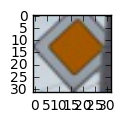

(32, 32, 3)


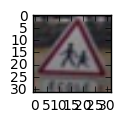

(32, 32, 3)


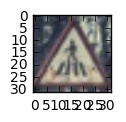

(32, 32, 3)


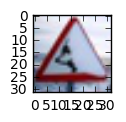

(32, 32, 3)


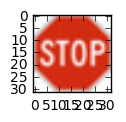

100%|██████████| 5/5 [00:00<00:00, 9408.49it/s]

image shape :  (32, 32, 3)
images :  (5, 32, 32, 1)


./lenano
Restored!
Predicted Labels
[23 25  0 41 26]

Top K : 
TopKV2(values=array([[  1.00000000e+00,   1.71838579e-08,   7.37007289e-10,
          1.60770300e-10,   1.54459709e-11],
       [  9.93635893e-01,   5.87078789e-03,   4.52459644e-04,
          3.16540063e-05,   8.56173483e-06],
       [  9.99989629e-01,   1.03925495e-05,   1.47911276e-15,
          8.02739159e-16,   3.02711285e-16],
       [  1.00000000e+00,   1.70690058e-08,   3.57400741e-11,
          1.97046418e-21,   8.12003241e-29],
       [  9.99938726e-01,   5.74958394e-05,   3.57000954e-06,
          1.02726638e-07,   6.63541542e-08]], dtype=float32), indices=array([[23, 22,  9, 27,  5],
       [25, 26, 20, 34, 16],
       [ 0, 36,  4, 28, 26],
       [41, 24, 33, 35, 38],
       [26,  5, 14, 38, 25]], dtype=int32))


In [330]:
## Run the predictions here.
### Feel free to use as many code cells as needed.
     
def run_predictions(path,imagesname):      
    images = load_images(path,imagesname)
    images = np.asarray(images).reshape(images.shape[0],images.shape[1],images.shape[2],1)
    print('images : ',images.shape)
    
    with tf.Session('', graph = tf.Graph()) as sess:
                saver = tf.train.import_meta_graph('./lenano.meta')
                #saver.restore(sess, tf.train.latest_checkpoint('.'))
                ckpt = str(tf.train.latest_checkpoint('.')) #tf.train.get_checkpoint_state('.')
                print(ckpt)
                if ckpt:
                    saver.restore(sess, ckpt)
                    print('Restored!')
                    
                    x = tf.placeholder(tf.float32,(5,32, 32, 1))
                    logits = LeNet2(x)
                    prediction = tf.nn.softmax(logits)
                    
                    sess.run(tf.global_variables_initializer())
                    new_predictions = sess.run(prediction, feed_dict={x: images})
                    top_k = sess.run(tf.nn.top_k(new_predictions, 5, sorted=True))
                    print("Predicted Labels")
                    print(np.argmax(new_predictions, 1))
                    print()
                    print('Top K : ')
                    print(top_k)
                    
                        
run_predictions('images/',imgnames)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** 
"""
I run my model vs a set of five signs :
Predicted Sign
-----------------
1/Road work sign - 25
2/Children crossing - 28
3/Pedastrian Crossing - 27
4/Double curve - 19
5/Stop sign - 14

Real signs :
1/Pedastrian Crossing - 27
2/End of no passing
3/Speed limit (100km/h)
4/30,Beware of ice/snow
5/Dangerous curve to the left

Only the Dangerous curve to the left sing was recognized which leads us to an accuracy of 20%
"""

(32, 32, 3)


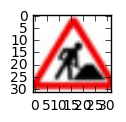

(32, 32, 3)


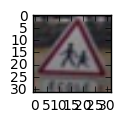

(32, 32, 3)


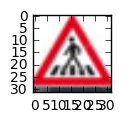

(32, 32, 3)


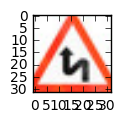

(32, 32, 3)


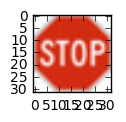

100%|██████████| 5/5 [00:00<00:00, 10225.02it/s]

image shape :  (32, 32, 3)
images :  (5, 32, 32, 1)


./lenano
Restored!
Predicted Labels
[27 15 12 12 39]

Top K : 
TopKV2(values=array([[  1.00000000e+00,   5.12064142e-19,   1.44480463e-21,
          6.12688954e-22,   3.21995207e-27],
       [  9.66630161e-01,   3.23932357e-02,   7.94296386e-04,
          1.18330347e-04,   5.50339719e-05],
       [  9.99999642e-01,   3.54828416e-07,   1.65766734e-10,
          2.31894278e-12,   1.32614669e-19],
       [  9.73564684e-01,   2.64139771e-02,   2.13874773e-05,
          9.22845550e-11,   1.69380578e-21],
       [  9.96897459e-01,   3.10258777e-03,   8.92164786e-10,
          1.97077160e-10,   4.94082365e-15]], dtype=float32), indices=array([[27, 18,  1, 40,  4],
       [15,  1, 27, 10,  3],
       [12, 37, 10,  7, 13],
       [12,  3, 42, 40, 41],
       [39, 42, 41, 12, 37]], dtype=int32))


In [337]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

imgnames = ['01.jpg', '02.jpg', '03.jpg', \
                '04.jpg', '05.jpg']

run_predictions('images/',imgnames)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.